# Logistic Regression

In this notebook, we explore LogisticRegression to predict if PA forms will be approved. We will be using Drug, BIN, Reject Code, and flags for Tried & Failed, Contraindication, and Correct Diagnosis for prediction. We also use LASSO to explore variable importance. First, we import the needed packages.

In [1]:
##Import packages
import pandas as pd
import numpy as np

## For plotting
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

In [2]:
## Import packages
## Logistic Regression, Lasso for feature selection
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Lasso

## Import splits and metrics
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import roc_auc_score, accuracy_score

Now, we create our train test split, making sure to stratify on PA approval. We choose our test size to be 20% of the available data, and use the same random seed in all other model notebooks. We will use the test set after choosing our final model (and not in this notebook).

In [3]:
#import cleaned CSV (no date information)
cmm_pa_clf_read = pd.read_csv("../Data/cmm_pa_clf.csv",index_col = 0)

#drop pa_approved for the predictors, only use it for target.
cmm_pa_clf_data = cmm_pa_clf_read.drop(columns = 'pa_approved').copy()
cmm_pa_clf_target = cmm_pa_clf_read['pa_approved'].copy()
X_train,X_test,y_train,y_test= train_test_split(cmm_pa_clf_data, cmm_pa_clf_target, test_size = 0.2, 
                                             random_state = 10475, shuffle = True,
                                            stratify = cmm_pa_clf_target)

## Baseline Model

Our baseline model will be predicting all claims will have PA approved, as the majority of claims are approved.

In [4]:
if y_train.value_counts(normalize=True)[1]>.5:
    print(np.round(y_train.value_counts(normalize=True)[1]*100,3),"percent of the training set has PA approved, so",
          "our baseline model will predict all PA forms are approved.")
else:
    print(np.round(y_train.value_counts(normalize=True)[1]*100,3),"percent of the training set has PA approved, so",
          "our baseline model will predict all PA forms are declined.")

73.445 percent of the training set has PA approved, so our baseline model will predict all PA forms are approved.


## Lasso
Here, we use Lasso for feature selection. Note that this identifies reject code, drug C, contraindiation, tried and failed, and bin 417740 as important, the same variables that showed up at the top of the decision tree in the Decision Tree notebook. However, all the variables last a similar amount as alpha increases, so we will keep them all moving forward.

In [5]:
alphas = [0.000001,.00001,.0001,.001,.01,.1,1,5,10,25,50,100]
features = X_train.columns.tolist()

## make coefficient holder
coefs = np.zeros((len(alphas), len(features)))

## Loop through alphas
for i in range(len(alphas)):
    ## make lasso model
    lasso = Lasso(alpha=alphas[i], max_iter=10000000)
    
    
    ## fit model
    lasso.fit(X_train, y_train)
    
    ## record coefs
    coefs[i,:] = lasso.coef_
pd.DataFrame(coefs, index=alphas, columns=features)   

,correct_diagnosis,tried_and_failed,contraindication,drug_B,drug_C,bin_417614,bin_417740,bin_999001,reject_code_75.0,reject_code_76.0
0.000001,0.038008,0.112558,-0.243912,-0.094623,-0.185767,0.068818,-0.001204,0.092958,0.493082,0.373351
0.000010,0.037952,0.112522,-0.243856,-0.094517,-0.185687,0.068717,-0.001275,0.092821,0.492972,0.373283
0.000100,0.037392,0.112160,-0.243298,-0.093457,-0.184887,0.067698,-0.001976,0.091454,0.491876,0.372603
0.001000,0.031794,0.108543,-0.237719,-0.082734,-0.176899,0.057245,-0.009288,0.076860,0.480896,0.366339
0.010000,0.000000,0.072333,-0.181774,-0.000000,-0.096685,0.000000,-0.042815,0.000000,0.386318,0.282130
0.100000,0.000000,0.000000,-0.000000,0.000000,-0.000000,-0.000000,-0.000000,0.000000,0.000000,0.000000
1.000000,0.000000,0.000000,-0.000000,0.000000,-0.000000,-0.000000,-0.000000,0.000000,0.000000,0.000000
5.000000,0.000000,0.000000,-0.000000,0.000000,-0.000000,-0.000000,-0.000000,0.000000,0.000000,0.000000
10.000000,0.000000,0.000000,-0.000000,0.000000,-0.000000,-0.000000,-0.000000,0.000000,0.000000,0.000000
25.000000,0.000000,0.000000,-0.000000,0.000000,-0.000000,-0.000000,-0.000000,0.000000,0.000000,0.000000


## Cross-Validation
We perform 5-fold cross validation to explore the accuracy rate and roc_auc as we change C, changing the regularization strength for LinearRegression.

In [6]:
#kfold cross validation, and C penalty range
kfold = StratifiedKFold(5, shuffle=True, random_state=10475)
Cs = [0.000001,.00001,.0001,.001,.01,.1,1,5,10,25,50,100]

#matrices to hold accuracy and ROC-AUC scores for validation sets and train subsets
cv_accs = np.zeros((5, len(Cs)+1))
cv_accs_train = np.zeros((5, len(Cs)+1))
cv_aucs = np.zeros((5, len(Cs)+1))
cv_aucs_train = np.zeros((5, len(Cs)+1))


i = 0
#loop through the cross-validation subsets
for train_index, test_index in  kfold.split(X_train, y_train):
    X_train_train = X_train.iloc[train_index]
    X_holdout = X_train.iloc[test_index]
    y_train_train  =  y_train.iloc[train_index]
    y_holdout = y_train.iloc[test_index]
    
    #baseline performance on the train and validation sets
    cv_accs_train[i,0] = accuracy_score(y_train_train, np.ones(len(y_train_train)))
    cv_aucs_train[i,0] = roc_auc_score(y_train_train, np.ones(len(y_train_train)))

    cv_accs[i,0] = accuracy_score(y_holdout, np.ones(len(y_holdout)))
    cv_aucs[i,0] = roc_auc_score(y_holdout, np.ones(len(y_holdout)))    
    
    j = 1
    #loop through the trees with varying depth
    for c in Cs:
        logreg=LogisticRegression(C=c)
        logreg.fit(X_train_train, y_train_train)
        
        #save scores for train subset and validation set
        cv_accs_train[i,j] = accuracy_score(y_train_train, logreg.predict(X_train_train))
        cv_aucs_train[i,j] = roc_auc_score(y_train_train, logreg.predict_proba(X_train_train)[:,1])
        
        cv_accs[i,j] = accuracy_score(y_holdout, logreg.predict(X_holdout))
        cv_aucs[i,j] = roc_auc_score(y_holdout, logreg.predict_proba(X_holdout)[:,1])
        j = j + 1
    i = i + 1

In [7]:
print("The accuracy scores:")
print("For training subsets:",np.mean(cv_accs_train,axis=0))
print("For the validation subsets:",np.mean(cv_accs,axis=0))
print("The ROC-AUC scores:")
print("For training subsets:",np.mean(cv_aucs_train,axis=0))
print("For the validation subsets:",np.mean(cv_aucs,axis=0))

The accuracy scores:
For training subsets: [0.73445229 0.73445229 0.73445229 0.77462901 0.81313293 0.81426668
 0.81423914 0.81420822 0.81420822 0.81420822 0.81420822 0.81420822
 0.81420822]
For the validation subsets: [0.73445229 0.73445229 0.73445229 0.77462901 0.81313293 0.81402105
 0.81389738 0.81396259 0.81396259 0.81396259 0.81396259 0.81396259
 0.81396259]
The ROC-AUC scores:
For training subsets: [0.5        0.86810229 0.86972587 0.87378516 0.87720877 0.87776947
 0.87790223 0.87789248 0.87789176 0.87789176 0.87789176 0.87789176
 0.87789176]
For the validation subsets: [0.5        0.86810486 0.8697251  0.8737764  0.87718559 0.87775558
 0.87788381 0.8778758  0.87787513 0.87787506 0.87787506 0.87787488
 0.87787496]


In [8]:
if np.argmax(np.mean(cv_accs,axis=0)==0):
    print("None of these models beat our baseline model on accuracy.")
else:
    
    print("The model with the best accuracy had a C value of",Cs[np.argmax(np.mean(cv_accs,axis=0))-1])
if np.argmax(np.mean(cv_accs,axis=0)==0):
    print("None of these models beat our baseline model on ROC AUC score.")
else:
    #if we change the depth range, this will automatically change, depth[0] is the minimum depth, the -1 compensates for the baseline at position 0
    print("The model with the best ROC AUC score had a C value of",Cs[np.argmax(np.mean(cv_aucs,axis=0))-1])

The model with the best accuracy had a C value of 0.01
The model with the best ROC AUC score had a C value of 0.1


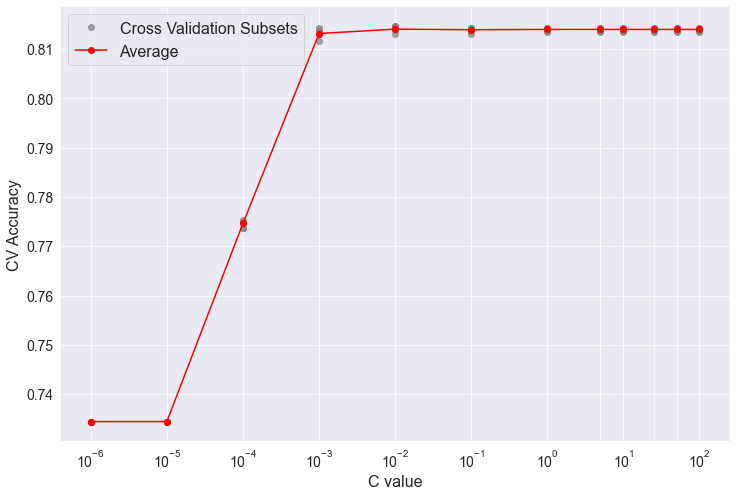

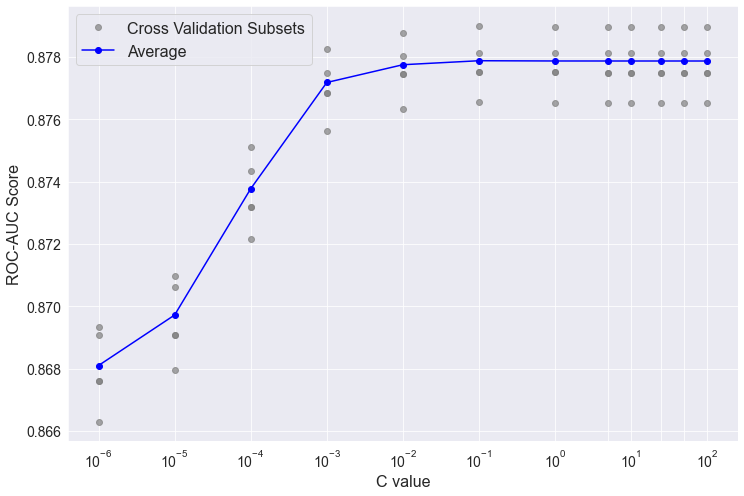

In [9]:
## this plots the average accuracy and accuracy for the CV subsets as a function of the maximum depth
plt.figure(figsize=(12,8))


#plot CV accuracies (one outside loop for non-repeating legend)
plt.plot(Cs,cv_accs[1,1:],'o',color='gray',alpha=.7,label='Cross Validation Subsets') 
for i in range(1,5):
    plt.plot(Cs,cv_accs[i,1:],'o',color='gray',alpha=.7,label='_no_legend_')
    
#Plot average CV accuracy 
plt.plot(Cs,np.mean(cv_accs[:,1:], axis=0),
         '-o',color='red',
         label="Average")

plt.legend(fontsize=16)

plt.xlabel("C value", fontsize=16)
plt.xscale("log")
plt.ylabel("CV Accuracy", fontsize=16)

plt.xticks(Cs, fontsize=14)
plt.yticks(fontsize=14)

plt.show()

## this plots the average ROC-AUC and ROC-AUC for the CV subsets as a function of the maximum depth
plt.figure(figsize=(12,8))

#plot CV ROC-AUC scores (one outside loop for non-repeating legend)
plt.plot(Cs,cv_aucs[1,1:],'o',color='gray',alpha=.7,label='Cross Validation Subsets') 
for i in range(1,5):
    plt.plot(Cs,cv_aucs[i,1:],'o',color='gray',alpha=.7,label='_no_legend_')
    
#Plot average CV accuracy 
plt.plot(Cs,np.mean(cv_aucs[:,1:], axis=0),
         '-o',color='blue',
         label="Average")

plt.legend(fontsize=16)

plt.xlabel("C value", fontsize=16)
plt.xscale("log")
plt.ylabel("ROC-AUC Score", fontsize=16)

plt.xticks(Cs, fontsize=14)
plt.yticks(fontsize=14)

plt.show()

Based on our cross-validation, our chosen Logistic Regression model will have $C=0.1$. We look at the ROC-AUC score and accuaracy score on the whole train set.

In [10]:
logreg=LogisticRegression(C=.1)
logreg.fit(X_train,y_train)

LogisticRegression(C=0.1)

In [11]:
pred=logreg.predict(X_train)
predplogreg.predict_proba(X_train)

print("For the chosen logistic regression model, the accuracy on the training set is",accuracy_score(y_train,pred))
print("For the chosen logistic regression model, the ROC-AUC on the training set is",roc_auc_score(y_train,predp))

NameError: name 'predplogreg' is not defined